In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.linalg import sqrtm
from scipy.stats import chi2 as chi2_p_value
import math
import scipy as sc

d=3
epsilon=1e-8
mu=0.5


# 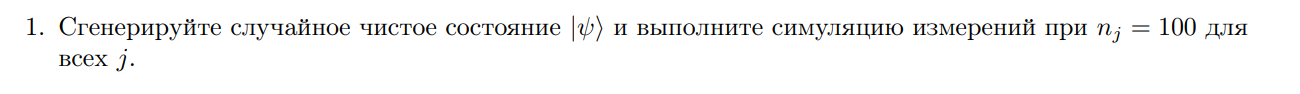

In [2]:
# mutually unbiased basises
w=np.exp(1j*2*np.pi/d)
A0=np.array([[1,0,0],[0,1,0],[0,0,1]])
A1=np.array([[1,1,1],[1,w,w**2],[1,w**2,w]])/np.sqrt(3)
A2=np.array([[1,1,1],[w,w**2,1],[w,1,w**2]])/np.sqrt(3)
A3=np.array([[1,1,1],[w**2,w,1],[w**2,1,w]])/np.sqrt(3)
A=np.array([A0,A1,A2,A3])

A_projectors=np.array([
    np.array([
        A[j].T[i].reshape((d,1))@(A[j].T[i].reshape((d,1)).T.conjugate())
        for i in range(d)])
    for j in range(d+1)])

# state preparation according to Haar measure
def get_psi(d=d):
    psi = np.reshape(np.array([np.random.normal() for i in range(d)]) + 1j*np.array([np.random.normal() for i in range(d)]), (d,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    return psi

# measurement
nj=100
def measurement(rho,A_projectors=A_projectors,counts=nj):
    p_Born=np.real(np.array([
    np.array([
        np.trace(A_projectors[i][j]@rho) for j in range(d)
    ]) for i in range(d+1)
]))
    return np.array([
        np.random.multinomial(counts, p_Born[i], size=1)
        for i in range(d+1)]).reshape((d**2+d,1))/counts

def frobenius_norm(matrix):
    return np.sqrt(np.sum(list(map(lambda x: np.abs(x) ** 2,matrix))))

In [3]:
psi=get_psi()
rho=psi@(psi.T.conjugate())
counts=measurement(rho)

# 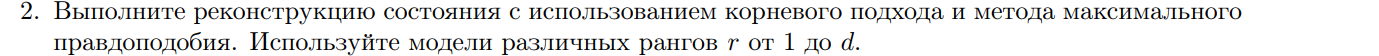

In [4]:
B=np.array([
    np.array([
        A_projectors[i][j].reshape(-1)
        for j in range(d)])
    for i in range(d+1)]).reshape((d**2+d,d**2))
u,s,v=np.linalg.svd(B)

i=np.diag(A_projectors.sum(axis=0).sum(axis=0)).mean() #i*I=np.eye(d) i is coeffitient of proportionality

def reconstruction(p,u=u,s=s,v=v,projection=True): #from Lab 2 p=counts
    if projection==False:
        q=u.T.conjugate()@p
        f=np.array([q[j]/s[j] for j in range(d**2)])
        return (v.T.conjugate()@f).reshape((d,d)).T
    else:
        q=u.T.conjugate()@p
        f=np.array([q[j]/s[j] for j in range(d**2)])
        rho=(v.T.conjugate()@f).reshape((d,d)).T

        val, vec=np.linalg.eigh(rho)
        val=np.round(val[::-1],10)
        vec=np.array([(vec.T[::-1])[i] for i in range(0,d)],dtype=complex).T
        
        omega=np.real(np.array([(val[:i+1:].sum()-1)/(i+1) for i in range(d)]))
        val_omega=np.array([val[i]-omega[i] for i in range(d)])
        j0=len(val_omega[val_omega>0])
        omega_0=omega[j0-1]
        val1=np.array([val[i]-omega_0 for i in range(j0)]+[0 for i in range(d-j0)])
         

        rhotest=vec@np.diag(val1)@(vec.T.conjugate())
        return rhotest
    
def J(p,psi,A_projectors=A_projectors):
    result=np.zeros((d,d),dtype=complex)
    rho=psi@(psi.T.conjugate())
    for i in range(d):
        for j in range(len(A_projectors)):
            result+=p[i+j*d][0]*(A_projectors[j][i])/np.trace(rho@(A_projectors[j][i]))
    return result     
    
    
def simplex_projection(rho):
    val, vec=np.linalg.eigh(rho)
    val=np.round(val[::-1],10)
    vec=np.array([(vec.T[::-1])[i] for i in range(0,d)],dtype=complex).T
    
        

        
    omega=np.real(np.array([(val[:i+1:].sum()-1)/(i+1) for i in range(d)]))
    val_omega=np.array([val[i]-omega[i] for i in range(d)])
    j0=len(val_omega[val_omega>0])
    omega_0=omega[j0-1]
    val1=np.array([val[i]-omega_0 for i in range(j0)]+[0 for i in range(d-j0)])
           

    return vec@np.diag(val1)@(vec.T.conjugate())

def root_approach(p,r,i=i,mu=mu,A_projectors=A_projectors,u=u,s=s,v=v,epsilon=epsilon,result="rho"):#p=counts, r rang
    initial=reconstruction(p,u=u,s=s,v=v,projection=True)
    val,vec=np.linalg.eigh(initial)
    val=np.round(val[::-1],10)
    vec=np.array([(vec.T[::-1])[i] for i in range(0,d)],dtype=complex).T
    psi_old=vec@np.sqrt(np.diag(val))
    psi_old=np.array([psi_old.T[i] for i in range(r)],dtype=complex).T
    norm=1
    while norm>epsilon:
        psi_new=(1-mu)*(1/i)*J(p=p,psi=psi_old,A_projectors=A_projectors)@psi_old+mu*psi_old
        norm=frobenius_norm(psi_new-psi_old)
        psi_old=psi_new
    if result=="rho":
        return simplex_projection((psi_new@psi_new.T.conjugate()))
    return psi_new  
        
def Fidelity(a,b):
    return np.real(np.trace(sqrtm(sqrtm(b)@a@sqrtm(b)))**2)    

def chi2_computing(rho,counts,A_projectors=A_projectors,nj=nj):
    value=0
    for i in range(d*(d+1)):
        value+=((counts[i][0]*nj-nj*np.trace(A_projectors[i//(d)][i%d]@rho))**2)/(nj*np.trace(A_projectors[i//(d)][i%d]@rho))
    return value.real
def freedom_degree_poly(r):
    return d*(d+1)-d-r*(2*d-r)
    

# 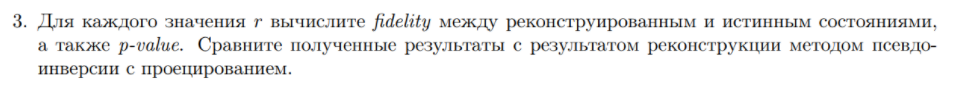

In [5]:
reconstruct_rho_1=root_approach(counts,1)
print("fidlity for pseudoinverse method "+ str(Fidelity(rho,reconstruction(counts))))
print("fidelity for r=1 "+str(Fidelity(rho,reconstruct_rho_1)))
reconstruct_rho_2=root_approach(counts,2)
print("fidelity for r=2 "+str(Fidelity(rho,reconstruct_rho_2)))
reconstruct_rho_3=root_approach(counts,3)
print("fidelity for r=3 "+str(Fidelity(rho,reconstruct_rho_3)))

fidlity for pseudoinverse method 0.9992796198583195
fidelity for r=1 0.9982930903700958
fidelity for r=2 0.9982930930377371
fidelity for r=3 0.9982930930377371


# 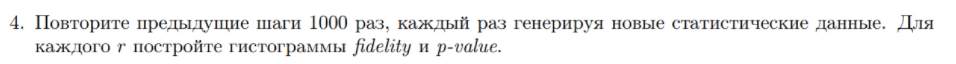

In [6]:
%%time
N=100
fidelity_samples_r1=np.array([])
fidelity_samples_r2=np.array([])
fidelity_samples_r3=np.array([])
fidelity_samples_pseudo_inverse=np.array([])
p_value_samples_r1=np.array([])
p_value_samples_r2=np.array([])
p_value_samples_pseudo_iversed=np.array([])
#degree of freedom
nu1=freedom_degree_poly(1)
nu2=freedom_degree_poly(2)
nu3=freedom_degree_poly(3)# this value equals 0. Therefore p-value for this r-value won't be computed
for i in range(N):
    psi=get_psi()
    rho=psi@(psi.T.conjugate())
    counts=measurement(rho)
    #computing density matrices
    rho_pseudo_inversed=reconstruction(counts)
    rho_reconstruct_1=root_approach(counts,1)
    rho_reconstruct_2=root_approach(counts,2)
    rho_reconstruct_3=root_approach(counts,3)
    #computing fidelity with true rho
    fidelity_samples_r1=np.append(fidelity_samples_r1,Fidelity(rho,rho_reconstruct_1))
    fidelity_samples_r2=np.append(fidelity_samples_r2,Fidelity(rho,rho_reconstruct_2))
    fidelity_samples_r3=np.append(fidelity_samples_r3,Fidelity(rho,rho_reconstruct_3))
    fidelity_samples_pseudo_inverse=np.append(fidelity_samples_pseudo_inverse,Fidelity(rho,rho_pseudo_inversed))
    #computing chi2-value
    chi2_1=chi2_computing(rho_reconstruct_1,counts)
    chi2_2=chi2_computing(rho_reconstruct_2,counts)
    chi2_pseudo_inversed=chi2_computing(rho_pseudo_inversed,counts)
    #computing p-values
    p_value_samples_r1 = np.append(p_value_samples_r1,1 - chi2_p_value.cdf(chi2_1, nu1))
    p_value_samples_r2 = np.append(p_value_samples_r2,1 - chi2_p_value.cdf(chi2_2, nu2))
    p_value_samples_pseudo_iversed = np.append(p_value_samples_pseudo_iversed,1 - chi2_p_value.cdf(chi2_pseudo_inversed, nu1))
    
    
    
    
    


Wall time: 21.3 s


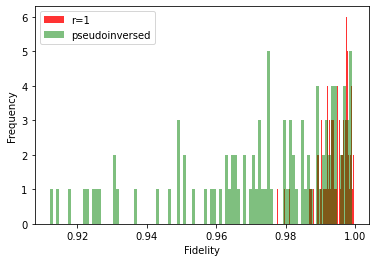

In [7]:
plt.hist(fidelity_samples_r1, bins=100, color='red', alpha=0.8, label='r=1')
plt.hist(fidelity_samples_pseudo_inverse, bins=100, color='green', alpha=0.5, label='pseudoinversed')
plt.legend(loc='upper left')
plt.xlabel("Fidelity")
plt.ylabel("Frequency")
plt.show()

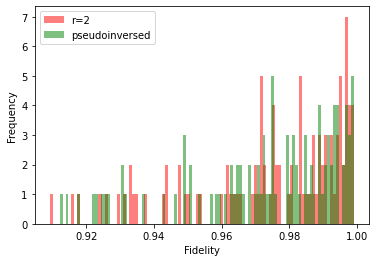

In [8]:
plt.hist(fidelity_samples_r2, bins=100, color='red', alpha=0.5, label='r=2')
plt.hist(fidelity_samples_pseudo_inverse, bins=100, color='green', alpha=0.5, label='pseudoinversed')
plt.legend(loc='upper left')
plt.xlabel("Fidelity")
plt.ylabel("Frequency")
plt.show()

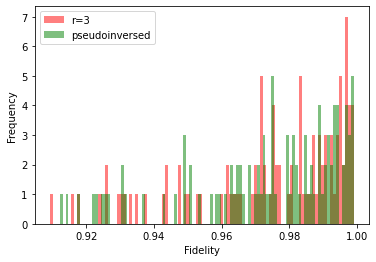

In [9]:
plt.hist(fidelity_samples_r3, bins=100, color='red', alpha=0.5, label='r=3')
plt.hist(fidelity_samples_pseudo_inverse, bins=100, color='green', alpha=0.5, label='pseudoinversed')
plt.legend(loc='upper left')
plt.xlabel("Fidelity")
plt.ylabel("Frequency")
plt.show()

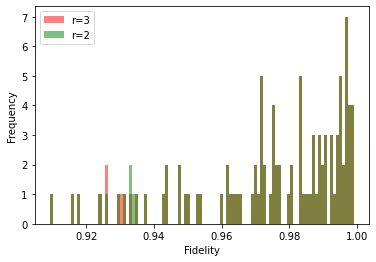

In [10]:
plt.hist(fidelity_samples_r3, bins=100, color='red', alpha=0.5, label='r=3')
plt.hist(fidelity_samples_r2, bins=100, color='green', alpha=0.5, label='r=2')
plt.legend(loc='upper left')
plt.xlabel("Fidelity")
plt.ylabel("Frequency")
plt.show()

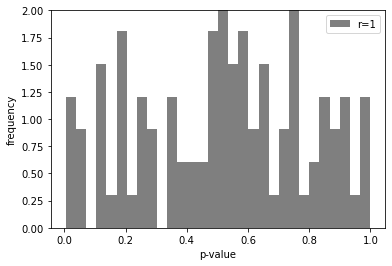

In [11]:
plt.hist(p_value_samples_r1, bins=30, alpha=0.5, density=True, label='r=1',color="black")


plt.ylim(0, 2)
plt.xlabel('p-value')
plt.ylabel('frequency')
plt.legend()
plt.show()

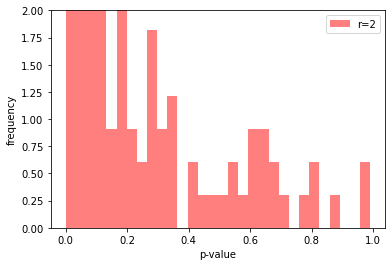

In [12]:

plt.hist(p_value_samples_r2, bins=30, alpha=0.5, density=True, label='r=2',color="red")


plt.ylim(0, 2)
plt.xlabel('p-value')
plt.ylabel('frequency')
plt.legend()
plt.show()

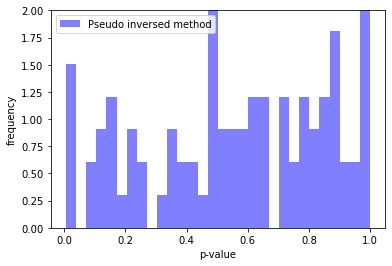

In [13]:

plt.hist(p_value_samples_pseudo_iversed, bins=30, alpha=0.5, density=True, label='Pseudo inversed method', color="blue")

plt.ylim(0, 2)
plt.xlabel('p-value')
plt.ylabel('frequency')
plt.legend()
plt.show()

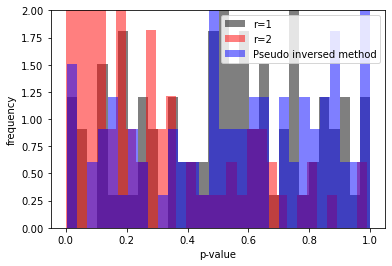

In [14]:
plt.hist(p_value_samples_r1, bins=30, alpha=0.5, density=True, label='r=1',color="black")
plt.hist(p_value_samples_r2, bins=30, alpha=0.5, density=True, label='r=2',color="red")
plt.hist(p_value_samples_pseudo_iversed, bins=30, alpha=0.5, density=True, label='Pseudo inversed method', color="blue")

plt.ylim(0, 2)
plt.xlabel('p-value')
plt.ylabel('frequency')
plt.legend()
plt.show()

# 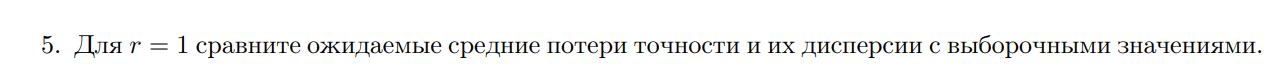

In [15]:
psi=get_psi()
rho=psi@(psi.T.conjugate())
counts=np.real(np.array([
    np.array([
        np.trace(A_projectors[i][j]@rho)
        for j in range(d)])
    for i in range(d+1)])).reshape((d*(d+1),1))
Psi=np.append(psi.real,psi.imag,axis=0)
A = np.array([[0, -1],
              [1, 0]])# auxiliary matrix for creation real projectors
P = np.array([np.kron(np.eye(2), A_projectors[i//(d)][i%d].real) + np.kron(A, A_projectors[i//(d)][i%d].imag) for i in range(d*(d+1))])
H = 2*np.array([
    (nj/counts[i][0])*(P[i]@Psi)@((P[i]@Psi).T) for i in range(d*(d+1))
]).sum(axis=0)
h=np.linalg.eigh(H)[0] #eigenvalues of the matrix of full information
d = 1/2/h[1:-1]
mean=d.sum()
sigma=2*(d**2).sum()

In [16]:
print("Expected fidelity loss for r=1")
print(str(np.round(mean,4))+"+/-"+str(np.round(np.sqrt(sigma),4)))
print("Obtained fidelity loss for r=1")
print(str(np.round((1-fidelity_samples_r1).mean(),4))+"+/-"+str(np.round((1-fidelity_samples_r1).std(),4)))

Expected fidelity loss for r=1
0.0052+/-0.0038
Obtained fidelity loss for r=1
0.0058+/-0.0042
